In [3]:
# !pip install lightgbm

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colors are set!')

from sklearn.model_selection import StratifiedKFold
print('sklearn imported!')

import lightgbm as lgb
print('lightgbm imported!')

My colors are set!
sklearn imported!
lightgbm imported!


In [5]:
train_set = pd.read_csv('./data/train.csv')
test_set = pd.read_csv('./data/test.csv')

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 143 features
test set has 23856 rows, and 142 features


In [6]:
target = train_set['Target']
target.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

In [7]:
#outlier in test set which rez_esc is 99.0
test_set.loc[test_set['rez_esc'] == 99.0 , 'rez_esc'] = 5

In [8]:
data_na = train_set.isnull().sum().values / train_set.shape[0] *100
df_na = pd.DataFrame(data_na, index=train_set.columns, columns=['Count'])
df_na = df_na.sort_values(by=['Count'], ascending=False)

missing_value_count = df_na[df_na['Count']>0].shape[0]

print(f'We got {missing_value_count} rows which have missing value in train set ')
df_na.head(6)

We got 5 rows which have missing value in train set 


,Count
rez_esc,82.954902
v18q1,76.823271
v2a1,71.779847
SQBmeaned,0.052318
meaneduc,0.052318
Id,0.000000


In [9]:
data_na = test_set.isnull().sum().values / test_set.shape[0] *100
df_na = pd.DataFrame(data_na, index=test_set.columns, columns=['Count'])
df_na = df_na.sort_values(by=['Count'], ascending=False)

missing_value_count = df_na[df_na['Count']>0].shape[0]

print(f'We got {missing_value_count} rows which have missing value in test set ')
df_na.head(6)

We got 5 rows which have missing value in test set 


,Count
rez_esc,82.381791
v18q1,75.980885
v2a1,72.950201
meaneduc,0.129946
SQBmeaned,0.129946
instlevel1,0.000000


In [11]:
#Fill na
def repalce_v18q1(x):
    if x['v18q'] == 0:
        return x['v18q']
    else:
        return x['v18q1']

train_set['v18q1'] = train_set.apply(lambda x : repalce_v18q1(x),axis=1)
test_set['v18q1'] = test_set.apply(lambda x : repalce_v18q1(x),axis=1)

train_set['v2a1'] = train_set['v2a1'].fillna(value=train_set['tipovivi3'])
test_set['v2a1'] = test_set['v2a1'].fillna(value=test_set['tipovivi3'])

In [12]:
cols = ['edjefe', 'edjefa']
train_set[cols] = train_set[cols].replace({'no': 0, 'yes':1}).astype(float)
test_set[cols] = test_set[cols].replace({'no': 0, 'yes':1}).astype(float)

In [13]:
train_set['roof_waste_material'] = np.nan
test_set['roof_waste_material'] = np.nan
train_set['electricity_other'] = np.nan
test_set['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

train_set['roof_waste_material'] = train_set.apply(lambda x : fill_roof_exception(x),axis=1)
test_set['roof_waste_material'] = test_set.apply(lambda x : fill_roof_exception(x),axis=1)
train_set['electricity_other'] = train_set.apply(lambda x : fill_no_electricity(x),axis=1)
test_set['electricity_other'] = test_set.apply(lambda x : fill_no_electricity(x),axis=1)

In [14]:
def owner_is_adult(x):
    if x['age'] <= 18:
        return 0
    else:
        return 1

train_set['head<18'] = train_set.apply(lambda x : owner_is_adult(x),axis=1)
test_set['head<18'] = test_set.apply(lambda x : owner_is_adult(x),axis=1)

In [15]:
train_set['adult'] = train_set['hogar_adul'] - train_set['hogar_mayor']
train_set['dependency_count'] = train_set['hogar_nin'] + train_set['hogar_mayor']
train_set['dependency'] = train_set['dependency_count'] / train_set['adult']
train_set['child_percent'] = train_set['hogar_nin']/train_set['hogar_total']
train_set['elder_percent'] = train_set['hogar_mayor']/train_set['hogar_total']
train_set['adult_percent'] = train_set['hogar_adul']/train_set['hogar_total']
test_set['adult'] = test_set['hogar_adul'] - test_set['hogar_mayor']
test_set['dependency_count'] = test_set['hogar_nin'] + test_set['hogar_mayor']
test_set['dependency'] = test_set['dependency_count'] / test_set['adult']
test_set['child_percent'] = test_set['hogar_nin']/test_set['hogar_total']
test_set['elder_percent'] = test_set['hogar_mayor']/test_set['hogar_total']
test_set['adult_percent'] = test_set['hogar_adul']/test_set['hogar_total']

train_set['rent_per_adult'] = train_set['v2a1']/train_set['hogar_adul']
train_set['rent_per_person'] = train_set['v2a1']/train_set['hhsize']
test_set['rent_per_adult'] = test_set['v2a1']/test_set['hogar_adul']
test_set['rent_per_person'] = test_set['v2a1']/test_set['hhsize']

train_set['overcrowding_room_and_bedroom'] = (train_set['hacdor'] + train_set['hacapo'])/2
test_set['overcrowding_room_and_bedroom'] = (test_set['hacdor'] + test_set['hacapo'])/2

train_set['no_appliances'] = train_set['refrig'] + train_set['computer'] + train_set['television']
test_set['no_appliances'] = test_set['refrig'] + test_set['computer'] + test_set['television']

train_set['r4h1_percent_in_male'] = train_set['r4h1'] / train_set['r4h3']
train_set['r4m1_percent_in_female'] = train_set['r4m1'] / train_set['r4m3']
train_set['r4h1_percent_in_total'] = train_set['r4h1'] / train_set['hhsize']
train_set['r4m1_percent_in_total'] = train_set['r4m1'] / train_set['hhsize']
train_set['r4t1_percent_in_total'] = train_set['r4t1'] / train_set['hhsize']
test_set['r4h1_percent_in_male'] = test_set['r4h1'] / test_set['r4h3']
test_set['r4m1_percent_in_female'] = test_set['r4m1'] / test_set['r4m3']
test_set['r4h1_percent_in_total'] = test_set['r4h1'] / test_set['hhsize']
test_set['r4m1_percent_in_total'] = test_set['r4m1'] / test_set['hhsize']
test_set['r4t1_percent_in_total'] = test_set['r4t1'] / test_set['hhsize']

train_set['rent_per_room'] = train_set['v2a1']/train_set['rooms']
train_set['bedroom_per_room'] = train_set['bedrooms']/train_set['rooms']
train_set['elder_per_room'] = train_set['hogar_mayor']/train_set['rooms']
train_set['adults_per_room'] = train_set['adult']/train_set['rooms']
train_set['child_per_room'] = train_set['hogar_nin']/train_set['rooms']
train_set['male_per_room'] = train_set['r4h3']/train_set['rooms']
train_set['female_per_room'] = train_set['r4m3']/train_set['rooms']
train_set['room_per_person_household'] = train_set['hhsize']/train_set['rooms']

test_set['rent_per_room'] = test_set['v2a1']/test_set['rooms']
test_set['bedroom_per_room'] = test_set['bedrooms']/test_set['rooms']
test_set['elder_per_room'] = test_set['hogar_mayor']/test_set['rooms']
test_set['adults_per_room'] = test_set['adult']/test_set['rooms']
test_set['child_per_room'] = test_set['hogar_nin']/test_set['rooms']
test_set['male_per_room'] = test_set['r4h3']/test_set['rooms']
test_set['female_per_room'] = test_set['r4m3']/test_set['rooms']
test_set['room_per_person_household'] = test_set['hhsize']/test_set['rooms']

train_set['rent_per_bedroom'] = train_set['v2a1']/train_set['bedrooms']
train_set['edler_per_bedroom'] = train_set['hogar_mayor']/train_set['bedrooms']
train_set['adults_per_bedroom'] = train_set['adult']/train_set['bedrooms']
train_set['child_per_bedroom'] = train_set['hogar_nin']/train_set['bedrooms']
train_set['male_per_bedroom'] = train_set['r4h3']/train_set['bedrooms']
train_set['female_per_bedroom'] = train_set['r4m3']/train_set['bedrooms']
train_set['bedrooms_per_person_household'] = train_set['hhsize']/train_set['bedrooms']

test_set['rent_per_bedroom'] = test_set['v2a1']/test_set['bedrooms']
test_set['edler_per_bedroom'] = test_set['hogar_mayor']/test_set['bedrooms']
test_set['adults_per_bedroom'] = test_set['adult']/test_set['bedrooms']
test_set['child_per_bedroom'] = test_set['hogar_nin']/test_set['bedrooms']
test_set['male_per_bedroom'] = test_set['r4h3']/test_set['bedrooms']
test_set['female_per_bedroom'] = test_set['r4m3']/test_set['bedrooms']
test_set['bedrooms_per_person_household'] = test_set['hhsize']/test_set['bedrooms']

train_set['tablet_per_person_household'] = train_set['v18q1']/train_set['hhsize']
train_set['phone_per_person_household'] = train_set['qmobilephone']/train_set['hhsize']
test_set['tablet_per_person_household'] = test_set['v18q1']/test_set['hhsize']
test_set['phone_per_person_household'] = test_set['qmobilephone']/test_set['hhsize']

train_set['age_12_19'] = train_set['hogar_nin'] - train_set['r4t1']
test_set['age_12_19'] = test_set['hogar_nin'] - test_set['r4t1']    

train_set['escolari_age'] = train_set['escolari']/train_set['age']
test_set['escolari_age'] = test_set['escolari']/test_set['age']

train_set['rez_esc_escolari'] = train_set['rez_esc']/train_set['escolari']
train_set['rez_esc_r4t1'] = train_set['rez_esc']/train_set['r4t1']
train_set['rez_esc_r4t2'] = train_set['rez_esc']/train_set['r4t2']
train_set['rez_esc_r4t3'] = train_set['rez_esc']/train_set['r4t3']
train_set['rez_esc_age'] = train_set['rez_esc']/train_set['age']
test_set['rez_esc_escolari'] = test_set['rez_esc']/test_set['escolari']
test_set['rez_esc_r4t1'] = test_set['rez_esc']/test_set['r4t1']
test_set['rez_esc_r4t2'] = test_set['rez_esc']/test_set['r4t2']
test_set['rez_esc_r4t3'] = test_set['rez_esc']/test_set['r4t3']
test_set['rez_esc_age'] = test_set['rez_esc']/test_set['age']

In [16]:
train_set['dependency'] = train_set['dependency'].replace({np.inf: 0})
test_set['dependency'] = test_set['dependency'].replace({np.inf: 0})

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 184 features
test set has 23856 rows, and 183 features


In [17]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

aggr_mean_list = ['rez_esc', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco2',
             'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',]

other_list = ['escolari', 'age', 'escolari_age']

for item in aggr_mean_list:
    group_train_mean = train_set[item].groupby(train_set['idhogar']).mean()
    group_test_mean = test_set[item].groupby(test_set['idhogar']).mean()
    new_col = item + '_aggr_mean'
    df_train[new_col] = group_train_mean
    df_test[new_col] = group_test_mean

for item in other_list:
    for function in ['mean','std','min','max','sum']:
        group_train = train_set[item].groupby(train_set['idhogar']).agg(function)
        group_test = test_set[item].groupby(test_set['idhogar']).agg(function)
        new_col = item + '_' + function
        df_train[new_col] = group_train
        df_test[new_col] = group_test

print(f'new aggregate train set has {df_train.shape[0]} rows, and {df_train.shape[1]} features')
print(f'new aggregate test set has {df_test.shape[0]} rows, and {df_test.shape[1]} features')

new aggregate train set has 2988 rows, and 46 features
new aggregate test set has 7352 rows, and 46 features


In [18]:
df_test = df_test.reset_index()
df_train = df_train.reset_index()

train_agg = pd.merge(train_set, df_train, on='idhogar')
test = pd.merge(test_set, df_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)
print(f'new train set has {train_agg.shape[0]} rows, and {train_agg.shape[1]} features')
print(f'new test set has {test.shape[0]} rows, and {test.shape[1]} features')

new train set has 9557 rows, and 230 features
new test set has 23856 rows, and 229 features


In [19]:
#According to data descriptions,ONLY the heads of household are used in scoring. /
#All household members are included in test + the sample submission, but only heads of households are scored.
train = train_agg.query('parentesco1==1')

In [20]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

C:\Users\jy\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


The most 20 positive feature: 
Target                  1.000000
escolari_mean           0.423626
escolari_max            0.373091
escolari                0.333791
meaneduc                0.331489
escolari_min            0.306693
cielorazo               0.295249
eviv3                   0.293540
instlevel8_aggr_mean    0.293307
epared3                 0.280947
escolari_age_min        0.276896
pisomoscer              0.275452
adult_percent           0.263882
etecho3                 0.261142
escolari_age_mean       0.258934
escolari_sum            0.256726
paredblolad             0.254469
edjefe                  0.235687
instlevel8              0.235102
escolari_age            0.232205
Name: Target, dtype: float64
**************************************************
The most 20 negative feature: 
child_percent       -0.263882
hogar_nin           -0.266309
dependency_count    -0.283908
dependency          -0.304563
child_per_room      -0.305541
child_per_bedroom   -0.308308
elimbasu5         

In [21]:
def evaluate_macroF1_lgb(predictions, truth):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.argmax(axis=1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', 1-f1) 

In [22]:
y = train['Target']

train.drop(columns=['Target'], inplace=True)


C:\Users\jy\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:

#parameter value is copied from 
clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.01, objective='multiclass',
                             random_state=2, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

In [24]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
y_val_list = []
y_val_pred_list = []
for train_index, test_index in kf.split(train, y):
    print("###")
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric = "logloss", early_stopping_rounds=400, verbose=100)
#     clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric = evaluate_macroF1_lgb, early_stopping_rounds=400, verbose=100)
    y_val_list.append(y_val)
    y_val_pred_list.append(clf.predict(X_val))
    predicts_result.append(clf.predict(test))

###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 1.15348
[200]	valid_0's multi_logloss: 1.07042
[300]	valid_0's multi_logloss: 1.03316
[400]	valid_0's multi_logloss: 1.01267
[500]	valid_0's multi_logloss: 1.00012
[600]	valid_0's multi_logloss: 0.994489
[700]	valid_0's multi_logloss: 0.991478
[800]	valid_0's multi_logloss: 0.990107
[900]	valid_0's multi_logloss: 0.98941
[1000]	valid_0's multi_logloss: 0.989733
[1100]	valid_0's multi_logloss: 0.989395
[1200]	valid_0's multi_logloss: 0.98918
[1300]	valid_0's multi_logloss: 0.988823
[1400]	valid_0's multi_logloss: 0.988634
[1500]	valid_0's multi_logloss: 0.986609
[1600]	valid_0's multi_logloss: 0.986309
[1700]	valid_0's multi_logloss: 0.986616
[1800]	valid_0's multi_logloss: 0.989801
[1900]	valid_0's multi_logloss: 0.992641
[2000]	valid_0's multi_logloss: 0.9946
Early stopping, best iteration is:
[1622]	valid_0's multi_logloss: 0.986051


C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 1.15825
[200]	valid_0's multi_logloss: 1.07108
[300]	valid_0's multi_logloss: 1.0272
[400]	valid_0's multi_logloss: 0.996353
[500]	valid_0's multi_logloss: 0.977581
[600]	valid_0's multi_logloss: 0.966125
[700]	valid_0's multi_logloss: 0.955164
[800]	valid_0's multi_logloss: 0.946543
[900]	valid_0's multi_logloss: 0.939844
[1000]	valid_0's multi_logloss: 0.9342
[1100]	valid_0's multi_logloss: 0.927739
[1200]	valid_0's multi_logloss: 0.922317
[1300]	valid_0's multi_logloss: 0.918173
[1400]	valid_0's multi_logloss: 0.916402
[1500]	valid_0's multi_logloss: 0.915398
[1600]	valid_0's multi_logloss: 0.915339
[1700]	valid_0's multi_logloss: 0.91583
[1800]	valid_0's multi_logloss: 0.918154
[1900]	valid_0's multi_logloss: 0.919502
Early stopping, best iteration is:
[1552]	valid_0's multi_logloss: 0.914746


C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 1.1475
[200]	valid_0's multi_logloss: 1.05916
[300]	valid_0's multi_logloss: 1.01947
[400]	valid_0's multi_logloss: 0.99483
[500]	valid_0's multi_logloss: 0.980276
[600]	valid_0's multi_logloss: 0.970243
[700]	valid_0's multi_logloss: 0.965068
[800]	valid_0's multi_logloss: 0.959114
[900]	valid_0's multi_logloss: 0.956287
[1000]	valid_0's multi_logloss: 0.952534
[1100]	valid_0's multi_logloss: 0.950492
[1200]	valid_0's multi_logloss: 0.948371
[1300]	valid_0's multi_logloss: 0.947004
[1400]	valid_0's multi_logloss: 0.946855
[1500]	valid_0's multi_logloss: 0.94849
[1600]	valid_0's multi_logloss: 0.94946
[1700]	valid_0's multi_logloss: 0.950342
Early stopping, best iteration is:
[1389]	valid_0's multi_logloss: 0.946784


C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 1.16093
[200]	valid_0's multi_logloss: 1.07835
[300]	valid_0's multi_logloss: 1.03675
[400]	valid_0's multi_logloss: 1.01535
[500]	valid_0's multi_logloss: 1.00013
[600]	valid_0's multi_logloss: 0.990822
[700]	valid_0's multi_logloss: 0.984931
[800]	valid_0's multi_logloss: 0.978671
[900]	valid_0's multi_logloss: 0.974374
[1000]	valid_0's multi_logloss: 0.972537
[1100]	valid_0's multi_logloss: 0.97036
[1200]	valid_0's multi_logloss: 0.968497
[1300]	valid_0's multi_logloss: 0.966166
[1400]	valid_0's multi_logloss: 0.966156
[1500]	valid_0's multi_logloss: 0.967679
[1600]	valid_0's multi_logloss: 0.969795
[1700]	valid_0's multi_logloss: 0.970489
Early stopping, best iteration is:
[1343]	valid_0's multi_logloss: 0.965593


C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 1.13217
[200]	valid_0's multi_logloss: 1.04296
[300]	valid_0's multi_logloss: 1.00165
[400]	valid_0's multi_logloss: 0.976997
[500]	valid_0's multi_logloss: 0.961209
[600]	valid_0's multi_logloss: 0.950654
[700]	valid_0's multi_logloss: 0.943153
[800]	valid_0's multi_logloss: 0.937018
[900]	valid_0's multi_logloss: 0.931261
[1000]	valid_0's multi_logloss: 0.925651
[1100]	valid_0's multi_logloss: 0.923184
[1200]	valid_0's multi_logloss: 0.921836
[1300]	valid_0's multi_logloss: 0.920968
[1400]	valid_0's multi_logloss: 0.92061
[1500]	valid_0's multi_logloss: 0.91866
[1600]	valid_0's multi_logloss: 0.918214
[1700]	valid_0's multi_logloss: 0.919335
[1800]	valid_0's multi_logloss: 0.91875
[1900]	valid_0's multi_logloss: 0.917631
[2000]	valid_0's multi_logloss: 0.917849
[2100]	valid_0's multi_logloss: 0.917601
[2200]	valid_0's multi_logloss: 0.918442
[2300]	valid_0's multi_logloss: 0.920104
[2400

C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\jy\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'LightGBM feature importance')

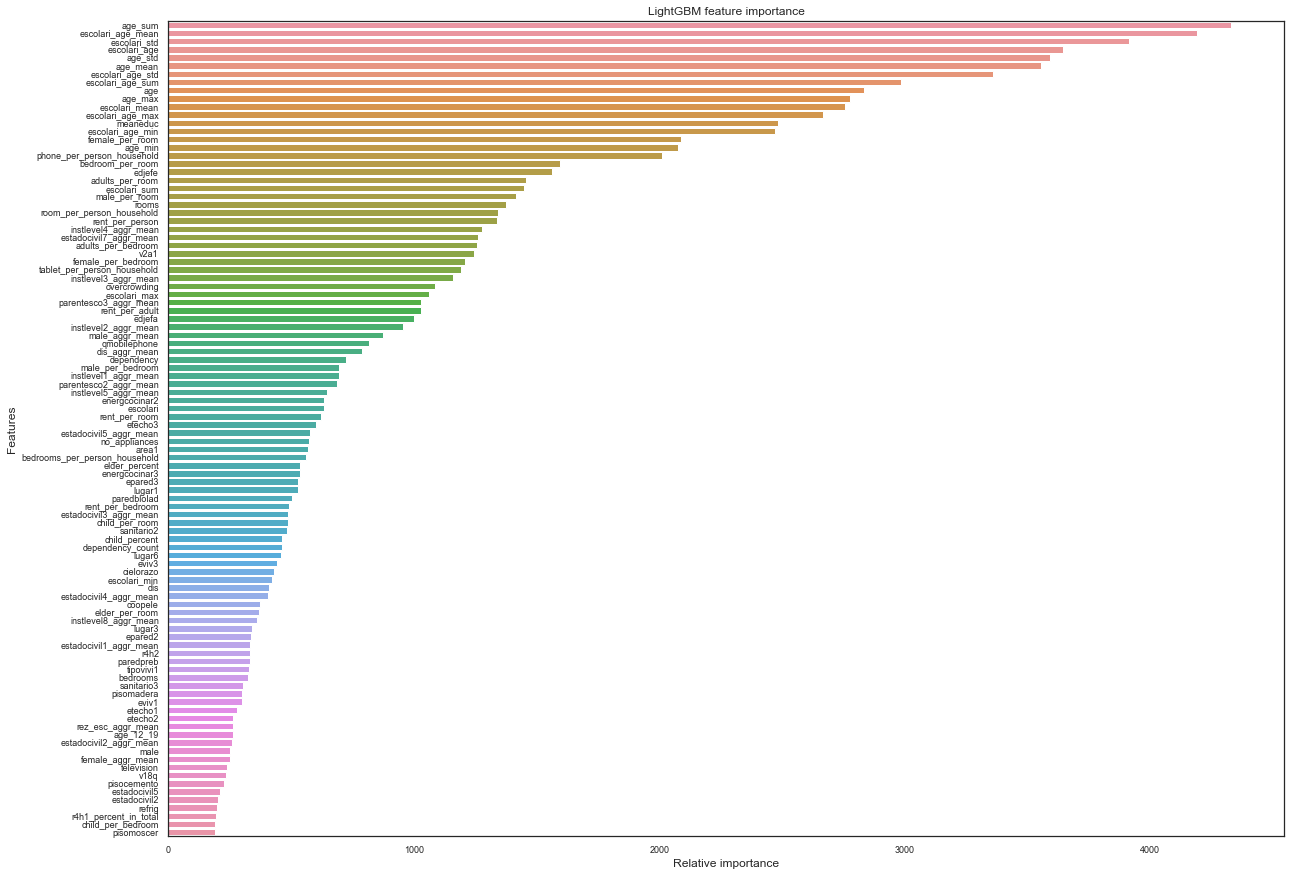

In [26]:
X = train
indices = np.argsort(clf.feature_importances_)[::-1]
top_100_indices = indices[:100]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=X.columns[top_100_indices], x = clf.feature_importances_[top_100_indices], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance")

In [ ]:
# from sklearn.metrics import f1_score
# f1_list = []
# for j in range(len(y_val_list)):
#     f1 = f1_score(y_val_pred_list[j], y_val_list[j], average='macro')
#     f1_list.append(f1)
#     print(f1)
# np.array(f1_list).mean()

In [ ]:
# evaluate_macroF1_lgb

In [ ]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('a_k10_4_submission.csv', index = False)